## Imports

In [36]:
from torch import nn
import torch
import platform
from typing import Callable, List, Optional, Dict
import numpy as np
import scipy.sparse as sp

print(torch.__version__)
print(torch.version.cuda)
print(platform.python_version())

from torch_geometric.data import (
    HeteroData,
    Data,
    InMemoryDataset,
    Batch
    )
from torch_geometric.data.storage import EdgeStorage
import torch_geometric.datasets as datasets
import torch_geometric.transforms as transforms
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

1.10.1+cu102
10.2
3.6.9


## Dataset creation

### Graph file locations

In [37]:
folders = ["/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/SurajAutomated/COMP_project/dotOutputs/execureQuery/*.txt", 
           "/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/SurajAutomated/COMP_project/dotOutputs/getTime/*.txt",
           "/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/SurajAutomated/COMP_project/dotOutputs/openConnection/*.txt",
           "/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/SurajAutomated/COMP_project/dotOutputs/readLine/*.txt"]

### Method to process raw graph data(in .txt format)

In [38]:
def get_nodes_edges(inTextFile, add_reverse_edges = False):
  # FD = 0, CD = 1
  # to support the hetero data object as suggested by the documentation 
  nodes_dict = {}
  edge_indices_CD = []
  edge_indices_FD = []

  #to support the Data object as used by the Entities dat object as used in RGAT source code
  edge_indices = []
  edge_type = []
  
  # nodes_dict is an index_map
  node_count=0
  with open(inTextFile) as fp:

    Lines = fp.readlines()
    for line in Lines:

      N = line.split('-->')
        
      #t1 = N[0].split('$$')   
      src = N[0].strip()   
      if src not in nodes_dict.keys():
        nodes_dict[src] = node_count
        node_count+=1
        
      #t2 = N[1].split('$$')
      right_idx = N[1].rfind('[')
      dst = N[1][:right_idx].strip()
      if dst not in nodes_dict.keys():
        nodes_dict[dst] = node_count
        node_count+=1

      x = N[1].strip()[right_idx + 1 : -1].strip()
      if(x == 'FD'):
        y=0
        edge_type.append(y)
        edge_indices.append([nodes_dict[src], nodes_dict[dst]])
        if add_reverse_edges:
          edge_type.append(y)
          edge_indices.append([nodes_dict[dst], nodes_dict[src]])
        edge_indices_FD.append([nodes_dict[src], nodes_dict[dst]])
      else: 
        y=1
        edge_type.append(y)
        edge_indices.append([nodes_dict[src], nodes_dict[dst]])
        if add_reverse_edges:
          edge_type.append(y)
          edge_indices.append([nodes_dict[dst], nodes_dict[src]])
        edge_indices_CD.append([nodes_dict[src], nodes_dict[dst]])
     
  return nodes_dict, edge_indices_FD, edge_indices_CD, edge_indices, edge_type

In [39]:
file = "/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/SurajAutomated/COMP_project/dotOutputs/execureQuery/example5_graph_dump.txt"

get_nodes_edges(file, add_reverse_edges = True)

({'Line_3 $$ public void testSetMaxRowsValues()': 0,
  'Line_4 $$ PreparedStatement ps = prepareStatement("values 0,1,2,3,4,5,6,7,8,9", ResultSet.TYPE_SCROLL_INSENSITIVE, ResultSet.CONCUR_READ_ONLY)': 1,
  'Line_7 $$ ps.setMaxRows(10)': 2,
  'Line_8 $$ JDBC.assertDrainResults(ps.executeQuery(), 10)': 3,
  'Line_8 $$ ps.executeQuery()': 4,
  'Line_9 $$ ps.setMaxRows(2)': 5,
  'Line_10 $$ JDBC.assertDrainResults(ps.executeQuery(), 2)': 6,
  'Line_10 $$ ps.executeQuery()': 7},
 [[1, 2], [1, 4], [1, 5], [1, 7]],
 [[0, 1], [0, 2], [0, 3], [0, 5], [0, 6]],
 [[0, 1],
  [1, 0],
  [0, 2],
  [2, 0],
  [1, 2],
  [2, 1],
  [0, 3],
  [3, 0],
  [1, 4],
  [4, 1],
  [0, 5],
  [5, 0],
  [1, 5],
  [5, 1],
  [0, 6],
  [6, 0],
  [1, 7],
  [7, 1]],
 [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0])

### Method to get CodeBERT embedding for nodes

In [40]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")

In [41]:
def get_node_embedding_from_codebert(nodes):
    list_of_embeddings = []
    for code_line in nodes.keys():
        code_line = code_line.split("$$")[1].strip()
        code_tokens=tokenizer.tokenize(code_line)
        tokens=[tokenizer.cls_token]+code_tokens+[tokenizer.eos_token]
        tokens_ids=tokenizer.convert_tokens_to_ids(tokens)
        context_embeddings=model(torch.tensor(tokens_ids)[None,:])
        cls_token_embedding = context_embeddings.last_hidden_state[0,0,:]
        list_of_embeddings.append(cls_token_embedding)
    return torch.stack(list_of_embeddings)

### Method to create data objects for GNN

In [42]:
import glob

dataset =[]
for label, folder in enumerate(folders):

  files = glob.glob(folder)
  for file in files:

    nodes_dict, edge_indices_FD, edge_indices_CD, edge_indices, edge_type = get_nodes_edges(file, add_reverse_edges = True)
    #print(nodes_dict, edge_indices_CD, edge_indices_FD, edge_type)

    # Node feature matrix with shape [num_nodes, num_node_features]=(N, 768).
    CodeEmbedding = get_node_embedding_from_codebert(nodes_dict)
    #print(CodeEmbedding.shape)

    # FIXING DATA FOTMATS AND SHAPE
    x = torch.tensor(CodeEmbedding)
    # print(x.shape)
  
    # data.y: Target to train against (may have arbitrary shape),
    # graph-level targets of shape [1, *]
    y = torch.tensor([label], dtype=torch.long)
    #print(type(y))

    # edge_index (LongTensor, optional) – Graph connectivity in COO format with shape [2, num_edges]
    edge_index_CD = torch.tensor(edge_indices_CD, dtype=torch.long).t().contiguous()
    edge_index_FD = torch.tensor(edge_indices_FD, dtype=torch.long).t().contiguous()
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_type = torch.tensor(edge_type, dtype=torch.long).t().contiguous()
    #print(edge_index_CD, edge_index_FD, edge_index, edge_type)
  
    data = Data(edge_index=edge_index, edge_type=edge_type, x=x)
    data.y = y
    data.num_nodes = len(nodes_dict)
    dataset.append(data)

print(dataset)

/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Data(x=[8, 768], edge_index=[2, 18], edge_type=[18], y=[1], num_nodes=8), Data(x=[11, 768], edge_index=[2, 24], edge_type=[24], y=[1], num_nodes=11), Data(x=[7, 768], edge_index=[2, 14], edge_type=[14], y=[1], num_nodes=7), Data(x=[4, 768], edge_index=[2, 6], edge_type=[6], y=[1], num_nodes=4), Data(x=[4, 768], edge_index=[2, 8], edge_type=[8], y=[1], num_nodes=4), Data(x=[4, 768], edge_index=[2, 8], edge_type=[8], y=[1], num_nodes=4), Data(x=[7, 768], edge_index=[2, 12], edge_type=[12], y=[1], num_nodes=7), Data(x=[5, 768], edge_index=[2, 12], edge_type=[12], y=[1], num_nodes=5), Data(x=[10, 768], edge_index=[2, 26], edge_type=[26], y=[1], num_nodes=10), Data(x=[5, 768], edge_index=[2, 8], edge_type=[8], y=[1], num_nodes=5), Data(x=[8, 768], edge_index=[2, 22], edge_type=[22], y=[1], num_nodes=8), Data(x=[6, 768], edge_index=[2, 20], edge_type=[20], y=[1], num_nodes=6), Data(x=[10, 768], edge_index=[2, 24], edge_type=[24], y=[1], num_nodes=10), Data(x=[6, 768], edge_index=[2, 10], ed

### Graph Statistics & Visualization

In [43]:
data = dataset[0]

print()
print(data)
print('=============================================================')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(data.edge_index)
print(data.edge_type)


Data(x=[8, 768], edge_index=[2, 18], edge_type=[18], y=[1], num_nodes=8)
Number of nodes: 8
Number of edges: 18
Average node degree: 2.25
Has isolated nodes: False
Has self-loops: False
Is undirected: True
tensor([[0, 1, 0, 2, 1, 2, 0, 3, 1, 4, 0, 5, 1, 5, 0, 6, 1, 7],
        [1, 0, 2, 0, 2, 1, 3, 0, 4, 1, 5, 0, 5, 1, 6, 0, 7, 1]])
tensor([1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0])


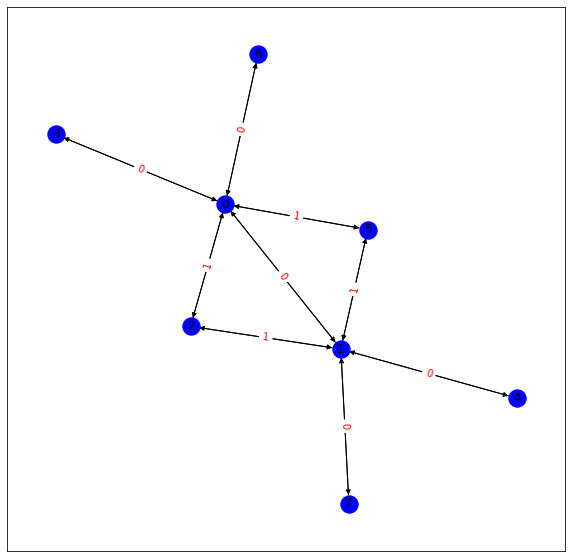

In [44]:
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(data, color):
    G = to_networkx(data, to_undirected=False)
    edge_labels = dict([((edge[0], edge[1]), int(label))
                    for edge, label in zip(G.edges(data=False), data.edge_type)])
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=color, cmap="Set2")
    nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G, seed=42), edge_labels=edge_labels, font_color='red')
    plt.show()

for G in dataset[:1]:
    visualize_graph(G, color="blue")

### Create train and test splits

In [45]:
import random

shuffled_dataset = random.sample(dataset, len(dataset))

train_dataset = shuffled_dataset[:15]
test_dataset = shuffled_dataset[15:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 15
Number of test graphs: 5


### Create the dataloaders

In [46]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 5
DataBatch(x=[33, 768], edge_index=[2, 76], edge_type=[76], y=[5], num_nodes=33, batch=[33], ptr=[6])

Step 2:
Number of graphs in the current batch: 5
DataBatch(x=[27, 768], edge_index=[2, 52], edge_type=[52], y=[5], num_nodes=27, batch=[27], ptr=[6])

Step 3:
Number of graphs in the current batch: 5
DataBatch(x=[32, 768], edge_index=[2, 74], edge_type=[74], y=[5], num_nodes=32, batch=[32], ptr=[6])



## Model

### Define the model

In [47]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features = 768, num_classes = 4):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        # 2. Readout layer
        graph_embedding = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(graph_embedding, p=0.5, training=self.training)
        x = self.lin(x)
        return x, graph_embedding

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(768, 64)
  (conv2): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=4, bias=True)
)


### Visualizing the embeddings

In [48]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap

def visualize_embeddings(h, color):
    z = umap.UMAP(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

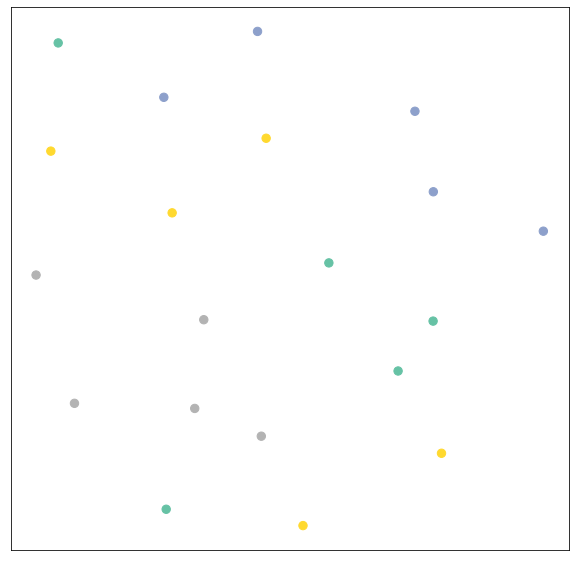

In [49]:
model = GCN(hidden_channels=64)

model.eval()
dataloader = DataLoader(dataset, len(dataset), shuffle=True)
for data in dataloader:
    out, graph_embedding = model(data.x, data.edge_index, data.batch)
    visualize_embeddings(graph_embedding, color=data.y)

## Training & Testing

In [50]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:  # Iterate in batches over the training dataset.
         out, _ = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         #print("Out = {} and Label = {}".format(out, data.y))
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
         total_loss += float(loss)
    print("Loss: ", total_loss)

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out, _ = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 20):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Loss:  7.4968801736831665
Epoch: 001, Train Acc: 0.2667, Test Acc: 0.2000
Loss:  4.550237059593201
Epoch: 002, Train Acc: 0.2667, Test Acc: 0.2000
Loss:  4.300608396530151
Epoch: 003, Train Acc: 0.2667, Test Acc: 0.2000
Loss:  4.113387107849121
Epoch: 004, Train Acc: 0.2667, Test Acc: 0.2000
Loss:  4.136639356613159
Epoch: 005, Train Acc: 0.3333, Test Acc: 0.2000
Loss:  4.1638641357421875
Epoch: 006, Train Acc: 0.3333, Test Acc: 0.2000
Loss:  4.155031442642212
Epoch: 007, Train Acc: 0.2667, Test Acc: 0.2000
Loss:  4.141993999481201
Epoch: 008, Train Acc: 0.4000, Test Acc: 0.2000
Loss:  4.044798851013184
Epoch: 009, Train Acc: 0.3333, Test Acc: 0.2000
Loss:  4.109871745109558
Epoch: 010, Train Acc: 0.3333, Test Acc: 0.2000
Loss:  4.010411620140076
Epoch: 011, Train Acc: 0.3333, Test Acc: 0.2000
Loss:  3.9722745418548584
Epoch: 012, Train Acc: 0.3333, Test Acc: 0.2000
Loss:  4.083296895027161
Epoch: 013, Train Acc: 0.3333, Test Acc: 0.2000
Loss:  4.001288890838623
Epoch: 014, Train Acc: 

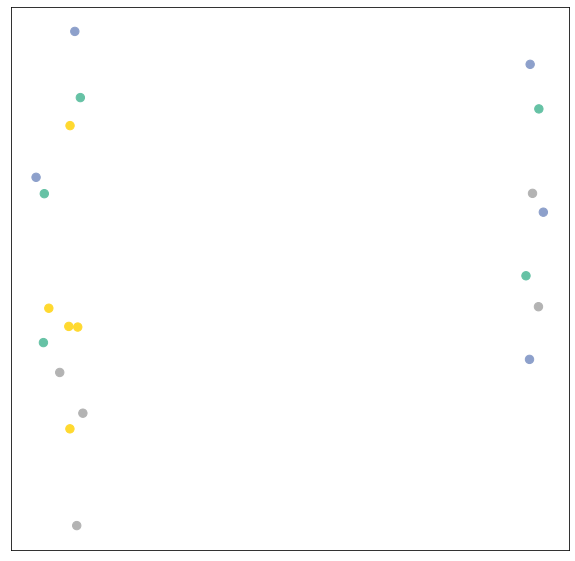

In [51]:
for data in dataloader:
    out, graph_embedding = model(data.x, data.edge_index, data.batch)
    visualize_embeddings(graph_embedding, color=data.y)